In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pprint as pp
%matplotlib inline
import gc 

In [2]:
train_df_raw= pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])
prop = pd.read_csv("properties_2016.csv") #, usecols=good_import_cols)

C:\Users\board\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


I was getting the error message:  
C:\Users\board\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)

### Remove and Impute Nulls 

In [3]:
# Number of missing values per column in property file 
missing_df = prop.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]

missing_df['missing_ratio'] = missing_df['missing_count'] / prop.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.75]

,column_name,missing_count,missing_ratio
2,architecturalstyletypeid,2979156,0.997970
3,basementsqft,2983589,0.999455
6,buildingclasstypeid,2972588,0.995769
9,decktypeid,2968121,0.994273
10,finishedfloor1squarefeet,2782500,0.932093
13,finishedsquarefeet13,2977545,0.997430
14,finishedsquarefeet15,2794419,0.936086
15,finishedsquarefeet50,2782500,0.932093
16,finishedsquarefeet6,2963216,0.992630
18,fireplacecnt,2672580,0.895272


In [4]:
# Create training data frame. Make parcel id the index 
train_df = train_df_raw.merge(prop, on='parcelid', how = 'left')
train_df.index = train_df.parcelid

In [5]:
# Impute the mean in the missing places for the remaining columns with missing values 
mean_values = train_df.mean(axis=0)
train_df2 = train_df.fillna(mean_values, inplace=True)

In [6]:
# Add the month to the data frame 
train_df2['transaction_month'] = np.float64(train_df2['transactiondate'].dt.month.values)
train_df2.groupby(by=['transaction_month']).logerror.count()

transaction_month
1.0      6556
2.0      6333
3.0      8652
4.0      9311
5.0      9961
6.0     10922
7.0      9947
8.0     10476
9.0      9575
10.0     4977
11.0     1826
12.0     1739
Name: logerror, dtype: int64

In [7]:
numb_unique_per_col = train_df2.T.apply(lambda x: x.nunique(), axis =1)
numb_unique_per_col.head()

parcelid                    90150
logerror                     1894
transactiondate               352
airconditioningtypeid           7
architecturalstyletypeid        7
dtype: int64

In [8]:
numb_unique_per_col[numb_unique_per_col == 1]

buildingclasstypeid    1
decktypeid             1
hashottuborspa         1
poolcnt                1
pooltypeid10           1
pooltypeid2            1
pooltypeid7            1
storytypeid            1
fireplaceflag          1
assessmentyear         1
taxdelinquencyflag     1
dtype: int64

In [9]:
cols_to_drop = numb_unique_per_col[numb_unique_per_col == 1].index

In [10]:
train_df.dtypes[train_df.dtypes != "float64"].index

Index(['parcelid', 'transactiondate', 'hashottuborspa',
       'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag',
       'taxdelinquencyflag'],
      dtype='object')

In [11]:
# Drop non numeric (float64) columns 
cols_to_drop = cols_to_drop.append(train_df.dtypes[train_df.dtypes != "float64"].index)
train_df2 = train_df.drop(cols_to_drop, axis = 1)


In [12]:
missing_df2 = train_df2.isnull().sum(axis=0).reset_index()
missing_df2.columns = ['count', 'val']
missing_df2[missing_df2['val'] > 0]


,count,val


In [13]:
train_df2.head()

,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,transaction_month
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,1.000000,7.229885,713.581395,2.0,3.0,4.000000,2.0,1347.974037,1684.0,...,311.694737,1959.0,1.440739,122754.0,360170.0,237416.0,6735.88,13.402692,6.037107e+13,1.0
14366692,-0.1684,1.816372,7.229885,713.581395,3.5,4.0,5.565407,3.5,1347.974037,2263.0,...,311.694737,2014.0,1.440739,346458.0,585529.0,239071.0,10153.02,13.402692,6.049151e+13,1.0
12098116,-0.0040,1.000000,7.229885,713.581395,3.0,2.0,4.000000,3.0,1347.974037,2217.0,...,311.694737,1940.0,1.440739,61994.0,119906.0,57912.0,11484.48,13.402692,6.037464e+13,1.0
12643413,0.0218,1.000000,7.229885,713.581395,2.0,2.0,4.000000,2.0,1347.974037,839.0,...,311.694737,1987.0,1.440739,171518.0,244880.0,73362.0,3048.74,13.402692,6.037296e+13,1.0
14432541,-0.0050,1.816372,7.229885,713.581395,2.5,4.0,5.565407,2.5,1347.974037,2283.0,...,311.694737,1981.0,2.000000,169574.0,434551.0,264977.0,5488.96,13.402692,6.059042e+13,1.0


### One hot encoding 

In [14]:
from sklearn.preprocessing import OneHotEncoder

In [15]:
one_hot_colnames_before = ["typeconstructiontypeid", "architecturalstyletypeid", "airconditioningtypeid", 
                    "heatingorsystemtypeid", "propertylandusetypeid", "transaction_month"]

In [16]:
#one_hot_df = OneHotEncoder().fit_transform(train_df2[one_hot_colnames].values)
one_hot_df = pd.DataFrame()
for col_name in one_hot_colnames_before:
    temp_one_hot_var1 = OneHotEncoder().fit_transform(train_df2[col_name].values.reshape(-1,1))
    temp_one_hot_var = temp_one_hot_var1.toarray()
    temp_one_hot_var_df1 = pd.DataFrame(data=temp_one_hot_var)
    temp_one_hot_var_df = temp_one_hot_var_df1.add_prefix(col_name + "_") # Add the name to each column 
    one_hot_df = pd.concat([one_hot_df, temp_one_hot_var_df] , axis = 1)
print("Data Frame Dimensions: " ,one_hot_df.shape)
one_hot_df.index = train_df2.index

Data Frame Dimensions:  (90275, 54)


In [17]:
one_hot_colnames_after = one_hot_df.columns

Find a better way to implement the code below 

In [18]:
train_df3 = train_df2.drop(one_hot_colnames_before, axis = 1)
train_df3 = pd.concat([train_df3, one_hot_df], axis = 1)

In [19]:
print("Dataset dimensions ",train_df3.shape)
train_df3.head()

Dataset dimensions  (90275, 94)


,logerror,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,...,transaction_month_2,transaction_month_3,transaction_month_4,transaction_month_5,transaction_month_6,transaction_month_7,transaction_month_8,transaction_month_9,transaction_month_10,transaction_month_11
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,713.581395,2.0,3.0,4.000000,2.0,1347.974037,1684.0,1684.0,1404.545455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14366692,-0.1684,713.581395,3.5,4.0,5.565407,3.5,1347.974037,2263.0,2263.0,1404.545455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12098116,-0.0040,713.581395,3.0,2.0,4.000000,3.0,1347.974037,2217.0,2217.0,1404.545455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12643413,0.0218,713.581395,2.0,2.0,4.000000,2.0,1347.974037,839.0,839.0,1404.545455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14432541,-0.0050,713.581395,2.5,4.0,5.565407,2.5,1347.974037,2283.0,2283.0,1404.545455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
del train_df2
gc.collect()

535

### Scale Data

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [22]:
cols_not_tp_scale = np.append(one_hot_colnames_after.values, 'logerror')

In [23]:
train_df_scale = StandardScaler().fit_transform(train_df3.drop(cols_not_tp_scale,axis = 1))
#train_df_scale = MinMaxScaler().fit_transform(train_df3.drop(cols_not_tp_scale),axis = 1)
train_df_scale = pd.DataFrame(train_df_scale)
train_df_scale.columns = (train_df3.drop(cols_not_tp_scale,axis = 1)).columns
train_df_scale.index = train_df3.index

In [24]:
train_df_scale.head()

,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,-1.204915e-14,-0.278287,-0.027558,-1.033247,-0.318860,-1.264756e-15,-0.096443,-0.069359,-1.096805e-13,0.0,...,0.0,5.086028e-15,-0.402849,8.543208e-16,-0.274761,-0.175719,-0.102173,0.109950,-1.396552e-14,-5.904822e-01
14366692,-1.204915e-14,1.215342,0.837173,0.000000,1.227922,-1.264756e-15,0.529670,0.584110,-1.096805e-13,0.0,...,0.0,5.086028e-15,1.921393,8.543208e-16,0.797193,0.230422,-0.098040,0.609633,-1.396552e-14,-5.247339e-12
12098116,-1.204915e-14,0.717466,-0.892289,-1.033247,0.712328,-1.264756e-15,0.479927,0.532194,-1.096805e-13,0.0,...,0.0,5.086028e-15,-1.205769,8.543208e-16,-0.565913,-0.608722,-0.550383,0.804331,-1.396552e-14,-5.729723e-01
12643413,-1.204915e-14,-0.278287,-0.892289,-1.033247,-0.318860,-1.264756e-15,-1.010201,-1.023039,-1.096805e-13,0.0,...,0.0,5.086028e-15,0.780401,8.543208e-16,-0.041092,-0.383494,-0.511805,-0.429215,-1.396552e-14,-5.811842e-01
14432541,-1.204915e-14,0.219590,0.837173,0.000000,0.196734,-1.264756e-15,0.551298,0.606682,-1.096805e-13,0.0,...,0.0,5.086028e-15,0.526848,2.151767e+00,-0.050407,-0.041670,-0.033355,-0.072385,-1.396552e-14,4.849422e-01


In [25]:
train_y = train_df['logerror']

In [26]:
train_y.size

90275

## Flooring and Capping 

In [27]:
ceil_y = train_y.quantile(q= 0.99)
floor_y = train_y.quantile(q=0.01)

In [28]:
train_df3['logerror'].describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

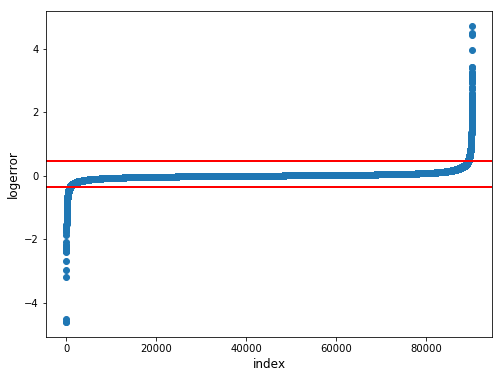

In [29]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df3['logerror'].size), np.sort(train_df3['logerror']))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.axhline(y = ceil_y, linewidth = 2, color = 'r')
plt.axhline(y = floor_y, linewidth = 2, color = 'r')
plt.show()

In [30]:
train_y[train_y > ceil_y] = ceil_y
train_y[train_y < floor_y] = floor_y

C:\Users\board\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\board\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


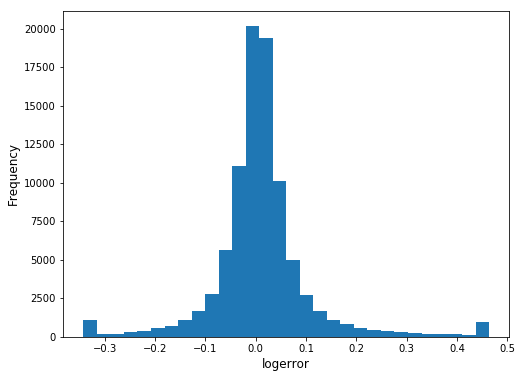

In [31]:
plt.figure(figsize=(8,6))
plt.hist(train_y, bins = 30)
plt.xlabel('logerror', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

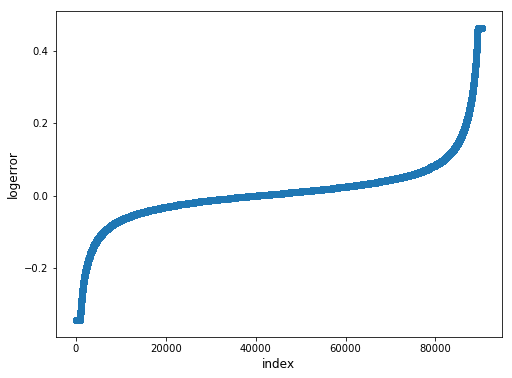

In [32]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_y.size), np.sort(train_y))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

In [33]:
print("Min value: ",min(train_y))
print("Max value: ", max(train_y)) 

Min value:  -0.3425
Max value:  0.463882


In [34]:
train_df_scale.shape

(90275, 39)

### Combine and Prepare for Modeling

In [35]:
train_df_modeling = pd.concat([train_df_scale, one_hot_df], axis = 1) 
train_df_modeling.head()

,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,...,transaction_month_2,transaction_month_3,transaction_month_4,transaction_month_5,transaction_month_6,transaction_month_7,transaction_month_8,transaction_month_9,transaction_month_10,transaction_month_11
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,-1.204915e-14,-0.278287,-0.027558,-1.033247,-0.318860,-1.264756e-15,-0.096443,-0.069359,-1.096805e-13,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14366692,-1.204915e-14,1.215342,0.837173,0.000000,1.227922,-1.264756e-15,0.529670,0.584110,-1.096805e-13,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12098116,-1.204915e-14,0.717466,-0.892289,-1.033247,0.712328,-1.264756e-15,0.479927,0.532194,-1.096805e-13,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12643413,-1.204915e-14,-0.278287,-0.892289,-1.033247,-0.318860,-1.264756e-15,-1.010201,-1.023039,-1.096805e-13,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14432541,-1.204915e-14,0.219590,0.837173,0.000000,0.196734,-1.264756e-15,0.551298,0.606682,-1.096805e-13,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
train_df_modeling.describe()

,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,...,transaction_month_2,transaction_month_3,transaction_month_4,transaction_month_5,transaction_month_6,transaction_month_7,transaction_month_8,transaction_month_9,transaction_month_10,transaction_month_11
count,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,...,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000
mean,-6.891806e-15,-4.360543e-15,1.516564e-16,-1.446135e-15,-1.999026e-15,-2.496674e-16,3.082565e-16,-3.810439e-16,-1.118359e-13,-2.078401e-17,...,0.095840,0.103140,0.110341,0.120986,0.110186,0.116045,0.106065,0.055132,0.020227,0.019263
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,...,0.294374,0.304144,0.313316,0.326113,0.313123,0.320281,0.307922,0.228238,0.140777,0.137450
min,-6.503072e+01,-2.269792e+00,-2.621751e+00,-3.013396e+00,-1.350048e+00,-7.253300e+00,-1.915307e+00,-1.967691e+00,-1.681313e+02,-8.576562e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.204915e-14,-2.782868e-01,-8.922893e-01,-1.033247e+00,-3.188600e-01,-1.264756e-15,-6.338839e-01,-6.268949e-01,-1.096805e-13,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.204915e-14,-2.782868e-01,-2.755836e-02,0.000000e+00,-3.188600e-01,-1.264756e-15,-2.445907e-01,-2.081784e-01,-1.096805e-13,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-1.204915e-14,7.174659e-01,8.371726e-01,9.469029e-01,7.123279e-01,-1.264756e-15,3.415118e-01,3.019561e-01,-1.096805e-13,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.917815e+01,1.764526e+01,1.121394e+01,4.247152e+00,1.824252e+01,3.491569e+01,2.267396e+01,2.061705e+01,8.656524e+01,9.594394e+01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
train_df_modeling.shape

(90275, 93)

### Neural Network Beginnings 

In [38]:
from keras.models import Sequential, Model  
from keras.layers import Dense, Activation, Dropout, Input, BatchNormalization 
from keras import losses 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD
import keras.backend as K
from time import time

Using TensorFlow backend.


In [39]:
def R_square(y_true, y_pred):
    print("True mean: ", K.mean(y_true))
    print("Pred mean: ", K.mean(y_pred))
    SS_res = K.sum(K.pow((y_true - y_pred),2))
    SS_tot = K.sum(K.pow((y_true - K.mean(y_true)),2))
    return (1-(SS_res/SS_tot))

In [43]:
# Hard coded input size 
def create_model(init1 = "normal", act1 = "relu", act2 = "relu"): 
    model = Sequential() 
    model.add(Dense(93, input_dim = 93, kernel_initializer = init1, activation=act1))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer = init1, activation = act2))
    model.add(Dense(10, kernel_initializer = init1, activation = act2))
    model.add(Dense(1, kernel_initializer= "normal", activation='linear'))
    model.compile(loss = 'mse', optimizer = 'adam', metrics = [R_square, 'mae'])
    return model


In [44]:
#filepath="weights.best.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='mae', verbose=1, save_best_only=True, mode='max')
stopping= EarlyStopping(monitor = 'R_square', patience  = 3, mode = "max")
tensorboard1 = TensorBoard(log_dir="C:/Users/board/Desktop/Kaggle/TensorBoard_Logs/Zillow/{}".format(time()),\
                           histogram_freq=1, write_graph= True, write_images = True)
callbacks_list = [stopping]#, tensorboard1]

In [45]:
# Remember to check input size 
model2 = create_model().fit(train_df_modeling.values, train_y.values, epochs = 50, validation_split = 0.2, batch_size = 30, 
                            callbacks = callbacks_list, verbose = 1)


True mean:  Tensor("Mean_14:0", shape=(), dtype=float32)
Pred mean:  Tensor("Mean_15:0", shape=(), dtype=float32)
Train on 72220 samples, validate on 18055 samples
Epoch 1/50
72220/72220 [==============================] - 5s - loss: 0.0102 - R_square: -0.0364 - mean_absolute_error: 0.0606 - val_loss: 0.0098 - val_R_square: -0.0405 - val_mean_absolute_error: 0.0589
Epoch 2/50
72220/72220 [==============================] - 4s - loss: 0.0101 - R_square: -0.0324 - mean_absolute_error: 0.0607 - val_loss: 0.0097 - val_R_square: -0.0296 - val_mean_absolute_error: 0.0592
Epoch 3/50
72220/72220 [==============================] - 5s - loss: 0.0101 - R_square: -0.0298 - mean_absolute_error: 0.0606 - val_loss: 0.0097 - val_R_square: -0.0301 - val_mean_absolute_error: 0.0592
Epoch 4/50
72220/72220 [==============================] - 5s - loss: 0.0101 - R_square: -0.0297 - mean_absolute_error: 0.0607 - val_loss: 0.0097 - val_R_square: -0.0262 - val_mean_absolute_error: 0.0588
Epoch 5/50
72220/72220 [

In [46]:
print(model2.history.keys())

dict_keys(['val_mean_absolute_error', 'val_loss', 'val_R_square', 'mean_absolute_error', 'R_square', 'loss'])


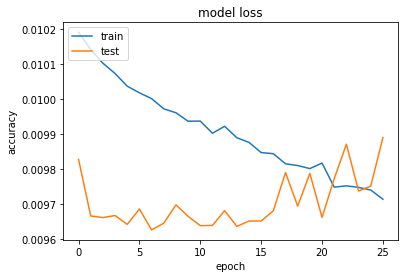

In [47]:
plt.plot(model2.history['loss'])
plt.plot(model2.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

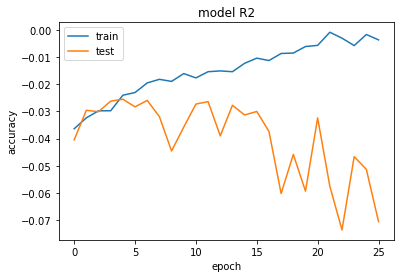

In [48]:
plt.plot(model2.history['R_square'])
plt.plot(model2.history['val_R_square'])
plt.title('model R2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

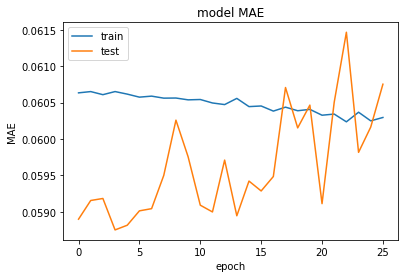

In [49]:
plt.plot(model2.history['mean_absolute_error'])
plt.plot(model2.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
def create_model2(epochs = 13, learning_rate = 0.001, momentum1 = 0.6, batch_size1 = 60, val_per = 0.15): 
    model = Sequential() 
    model.add(Dense(56, input_dim = train_df_scale.shape[1], init = 'uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(56,kernel_initializer = 'uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(52, kernel_initializer = 'uniform', activation = 'tanh'))
    model.add(BatchNormalization())
    model.add(Dense(26, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(1, kernel_initializer= 'normal'))
    decay_rate = learning_rate/epochs
    sgd = SGD(lr = learning_rate, momentum = momentum1, decay = decay_rate, nesterov = False )
    model.compile(loss = 'mae', optimizer = sgd, metric = ['R_square'])
    model.fit(train_df_scale, train_y, validation_split = val_per, epochs = epochs, batch_size = batch_size1, verbose = 1)
    return model

In [ ]:
batch_model = create_model2()

### Submission Steps

In [ ]:
train_df_new = pd.read_csv("train_2016.csv")
test = pd.read_csv("sample_submission.csv")
prop = pd.read_csv("properties_2016.csv")

In [ ]:
test['parcelid'] = test['ParcelId']
df_test = test.merge(prop, on='parcelid', how = 'left') 
print("Test DF len: " ,len(df_test))
print("Input DF len: ", len(test))

In [ ]:
train_cols1 = train_cols[1:len(train_cols)]

In [ ]:
x_test2 = df_test[train_cols1]
test_mean_values = x_test2.mean(axis=0)
x_test1 = x_test2.fillna(test_mean_values, inplace=True)
x_test = StandardScaler().fit_transform(x_test1)

In [ ]:
predictions = batch_model.predict(x_test)

In [ ]:
sub = pd.read_csv("sample_submission.csv")
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = predictions

In [ ]:
sub.to_csv('nn_starter2.csv', index=False, float_format='%.4f')

In [ ]:
sub.shape